<a href="https://colab.research.google.com/github/cboyda/MachineLearning/blob/main/PA3_Team1_W23_ipynd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PA3: k-NN**

Team member names:

*  Brett Adams
*  Cailenys Leslie
*  Clinton Boyda
*  Tanvir Hossain
*  Ram Dershan

Dataset: 
[New York City Airbnb Open Data](https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data)

In [158]:
import numpy as np
import pandas as pd
from sklearn import datasets
from sklearn import model_selection
from  sklearn import neighbors
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [159]:
# Connect to Dataset

filename = "https://raw.githubusercontent.com/cboyda/MachineLearning/main/AB_NYC_2019.csv"

df = pd.read_csv(filename)

# we can work on merging the new dataset in the code below = Brett?

# **Feature Scaling**


In [160]:
#drop all columns not necessary

In [161]:
df.drop(['id','host_id','latitude','longitude'], axis=1, inplace = True)
# df.drop('a', inplace=True, axis=1)

In [162]:
numeric_data = df.select_dtypes(include=[np.number])
categorical_data = df.select_dtypes(exclude=[np.number])


In [163]:
#define clean as duplicate
df_clean = df.copy()

### 1. Check extreme values:

a. Define what an extreme value is for each feature, e.g., using boxplots.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning:

Pass t

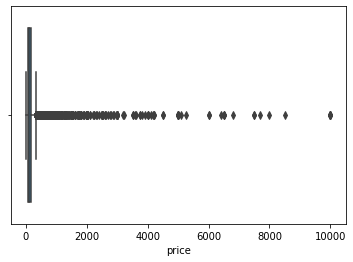

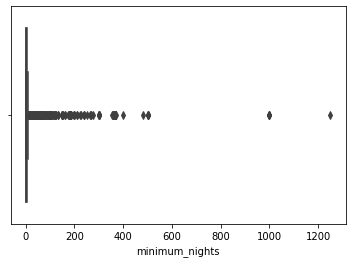

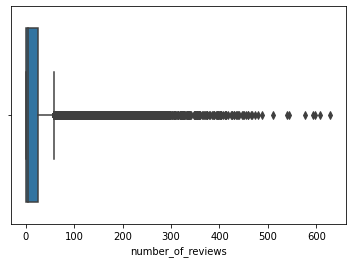

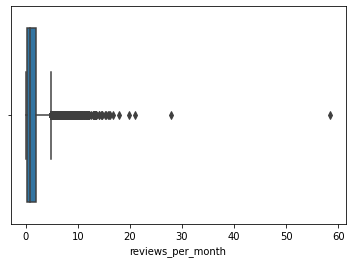

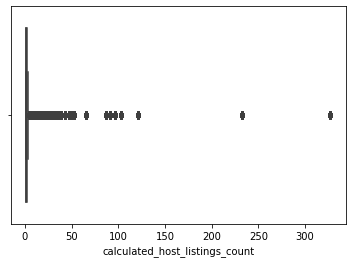

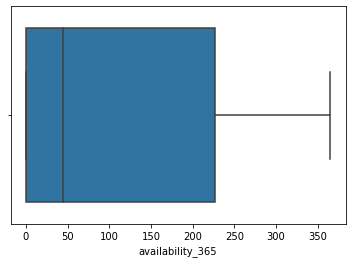

In [164]:
# create boxplots
for column in numeric_data.columns:
    plt.figure()            
    sns.boxplot(numeric_data[column])

In [165]:
# let's try looking at the histograms so the box plots are easier to read
for column in numeric_data.columns:
  fig = px.histogram(df, x=column, marginal="box")
  fig.show()

In [186]:
extreme_values = []

In [191]:
for column in numeric_data.columns:
  # Select the first quantile
  q1 = df[column].quantile(0.25)

  # Select the third quantile
  q3 = df[column].quantile(0.75)

  max = df[column].quantile(1)

  # Create a mask inbetween q1 & q3
  IQR = q3 - q1

  # Filtering the initial dataframe with a mask
  #filtered = df.query('(@q1 - 1.5 * @IQR) <= [column] <= (@q3 + 1.5 * @IQR)')
  # Filtering Values between Q1-1.5IQR and Q3+1.5IQR  

  #maximum outliers
  bottom_fence = 0 if (q1 - 1.5 * IQR) < 0 else q1 - 1.5 * IQR
  upper_fence = max if (q3 + 1.5 * IQR) > max else (q3 + 1.5 * IQR)
  #display(column, bottom_fence, upper_fence)
  extreme_values.append([column, bottom_fence, upper_fence])


6

[['price', 0, 334.0],
 ['minimum_nights', 0, 11.0],
 ['number_of_reviews', 0, 58.5],
 ['reviews_per_month', 0, 4.765000000000001],
 ['calculated_host_listings_count', 0, 3.5],
 ['availability_365', 0, 365.0]]

In [128]:
df.describe(include=['int64' , 'float64']).loc[['std','min','max','75%']]

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
std,240.15417,20.51055,44.550582,1.680442,32.952519,131.622289
min,0.00000,1.00000,0.000000,0.010000,1.000000,0.000000
max,10000.00000,1250.00000,629.000000,58.500000,327.000000,365.000000
75%,175.00000,5.00000,24.000000,2.020000,2.000000,227.000000


In [132]:
df.describe()


,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [ ]:
# how many rows in our entire data?
df.shape

(48895, 16)

In [ ]:
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

b. Do any of your features contain extreme values? List the features & the number of extreme values for each feature.


In [ ]:
# confirm standard deviatin for price is too large = needs to drop extreme values
df.describe(include='all').loc['std']

id                                 10983108.38561
name                                          NaN
host_id                           78610967.032667
host_name                                     NaN
neighbourhood_group                           NaN
neighbourhood                                 NaN
latitude                                  0.05453
longitude                                0.046157
room_type                                     NaN
price                                   240.15417
minimum_nights                           20.51055
number_of_reviews                       44.550582
last_review                                   NaN
reviews_per_month                        1.680442
calculated_host_listings_count          32.952519
availability_365                       131.622289
Name: std, dtype: object

In [ ]:
# how many rows our price column?
df.price.count()

48895

In [207]:
# lookup in extreme_values UPPER/LOWER FENCE values
def get_upperfence(name=''):
  for i in range(len(extreme_values)):
    if extreme_values[i][0] == name:
      return extreme_values[i][2]
    else:
      continue

def get_lowerfence(name=''):
  for i in range(len(extreme_values)):
    if extreme_values[i][0] == name:
      return extreme_values[i][1]
    else:
      continue


In [205]:
# looking at price specifically 75% is 175 but max is 10,000 so
# what is a good 'extreme' value? boxplot shows this as 374
df.loc[df.price > get_upperfence('price'), 'price'].count()

2972

In [206]:
# list of all rows that show price > extreme
df.loc[df.price > get_upperfence('price')]

,name,host_name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
61,Sunny & Spacious Chelsea Apartment,Petra,Manhattan,Chelsea,Entire home/apt,375,180,5,2018-11-03,0.12,1,180
85,perfect for a family or small group,Maggie,Brooklyn,Brooklyn Heights,Entire home/apt,800,1,25,2016-08-04,0.24,1,7
103,2000 SF 3br 2bath West Village private townhouse,Ann,Manhattan,West Village,Entire home/apt,500,4,46,2019-05-18,0.55,2,243
114,2 BR / 2 Bath Duplex Apt with patio! East Village,Bruce,Manhattan,East Village,Entire home/apt,350,2,7,2017-08-09,0.06,4,298
121,3 Story Town House in Park Slope,Vero,Brooklyn,South Slope,Entire home/apt,400,2,16,2018-12-30,0.24,2,216
...,...,...,...,...,...,...,...,...,...,...,...,...
48758,"Rustic Garden House Apt, 2 stops from Manhattan",LaGabrell,Queens,Long Island City,Entire home/apt,350,2,0,NaN,NaN,1,364
48833,Brand New 3-Bed Apt in the Best Location of FiDi,Yue,Manhattan,Financial District,Entire home/apt,475,2,0,NaN,NaN,1,64
48839,Massage Spa. Stay overnight. Authors Artist dr...,Richard,Brooklyn,Sheepshead Bay,Private room,800,1,0,NaN,NaN,1,23
48842,LUXURY MANHATTAN PENTHOUSE+HUDSON RIVER+EMPIRE...,LuxuryApartmentsByAmber,Manhattan,Chelsea,Entire home/apt,350,1,0,NaN,NaN,1,9


feature = availability_365 shows an extreme value for the value zero, and this really means that unit isn't available so best we just drop those indices to ensure we are only looking at available units!


In [107]:
df.loc[df.availability_365 == 0, 'availability_365'].count()

17533

In [193]:
df[df.availability_365 == 0]

,name,host_name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
4,Entire Apt: Spacious Studio/Loft by central park,Laura,Manhattan,East Harlem,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
6,BlissArtsSpace!,Garon,Brooklyn,Bedford-Stuyvesant,Private room,60,45,49,2017-10-05,0.40,1,0
8,Cozy Clean Guest Room - Family Apt,MaryEllen,Manhattan,Upper West Side,Private room,79,2,118,2017-07-21,0.99,1,0
14,West Village Nest - Superhost,Alina,Manhattan,West Village,Entire home/apt,120,90,27,2018-10-31,0.22,1,0
20,Sweet and Spacious Brooklyn Loft,Chaya,Brooklyn,Williamsburg,Entire home/apt,299,3,9,2011-12-28,0.07,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
48550,Sunny room with private entrance in shared home,Tiffany,Queens,Ridgewood,Private room,45,1,0,NaN,NaN,1,0
48731,Sunlight charming apt. in the heart of Brooklyn,Luciana Paula,Brooklyn,Park Slope,Entire home/apt,111,8,0,NaN,NaN,1,0
48756,Murray Hill Masterpiece,David,Manhattan,Murray Hill,Entire home/apt,129,2,0,NaN,NaN,1,0
48760,"Sunnyside, Queens 15 Mins to Midtown Clean & C...",Brandon,Queens,Sunnyside,Private room,46,1,0,NaN,NaN,1,0


In [71]:
# calculate percentage of values over our extreme, if under 5% consider dropping
display ('Availability_365 percentage over extreme:')
(df.loc[df.availability_365 == 0, 'availability_365'].count() / df.availability_365.count()) * 100 

'Availability_365 percentage over extreme:'

35.858472236424994

Normally dropping 36% of the values would NOT be considered a good solution, but we assuming availability_365 is a range from 0 to 365.  If a unit is 0, this means the owner did not put it for rent for ANY days that year.  So why even offer that as a solution to a potential renter?  We interpret this to mean that 36% of inventory (rooms to rent) were simply not available during this period and that is not part of the business problem we are trying to solve nor analyze.

In [106]:
df_clean.drop(df_clean[df_clean['availability_365'] == 0].index, inplace = True)

In [110]:
df_clean.shape

(31362, 16)

c. Do the number of extreme values make-up a substantial portion of that feature? (e.g. 5%) Or are they so few that you could consider dropping those samples? Explain.


In [114]:
df.loc[df.price > 374, 'price'].count()

2335

In [ ]:
# calculate percentage of values over our extreme, if under 5% consider dropping
display ('Pricing percentage over extreme:')
(df.loc[df.price > 374, 'price'].count() / df.price.count()) * 100 

'Pricing percentage over extreme:'

4.7755394212087126

Create new df_clean set with the extreme pricing values removed.

In [112]:
df_clean.drop(df_clean[df_clean['price'] > 374].index, inplace = True)

In [113]:
df_clean.shape

(29538, 16)

### 2. Min-max scale your data and store this in a variable name that indicates that you’ve min-max scaled the data, e.g., X_train_minmax.

### 3. Standardize your data and store this in a variable name that indicates that you’ve standardized the data, e.g., X_train_standard.


### 4. Visual & numeric comparison 1: Choose 3 features, and compare their standard deviations of after standardizing & min-max scaling. What is the difference between these two approaches on how your features are distributed [Hint: look at the mean].


### 5. Visual & numeric comparison 2: Generate a boxplot for all three datasets, the original, the  min-max scaled, and the standardized dataset. We expect to see a comparison like the one in lab, where each box-n-whiskers plot corresponds to a different feature.


# **Exploring k-NN construction:**

### 1. Vary the n_neighbors parameter:

a. Create a k-NN classifier model querying 5 neighbors.

b. Create a k-NN classifier model querying 11 neighbors.

c. Create a k-NN classifier model querying 15 neighbors.

###2. Vary the weights parameter:

a. Create a k-NN classifier model with weights parameter set to “uniform”.

b. Create a k-NN classifier model with weights parameter set to “distance”.

# **k-NN evaluation:**

### 3. Plot the decision boundaries for each class for the different n_neighbors and weights.


### 4. Use the sklearn.metrics.accuracy_score method to compare the accuracy of the several values of k, k=5, 11, and 15, and compare your original and your normalized (min-max scaled and standardized) datasets.


### 5. Test the performance of each k-NN classifier using other evaluation metrics (precision, recall and F1 scores) and see if there is any difference if you chose different metrics.


### 6. Imagine that you have another classifier that always predicts the most common label, do a baseline comparison for your ML models.


### 7. Generate a simple plot of the test and training learning curve for each k-NN and check if you have a low/high bias or low/high variance learning. We can use the function learning_curve to generate the values that are required to plot such a learning curve (number of samples that have been used, the average scores on the training sets and the average scores on the validation sets):
